# San Francisco Bike Share Reallocation Strategy methodology

Run through each day in the given dataset (filtering out before all of the stations opened). For each day, use the model
predictions of bike outflow by the hour and bikes available to rank the most important stations that should try to be reallocated. Demand is indicated by the OUTflow predicted values, so the optimum solution would be to direct more bikes to 
stations that experience more outflow. The allocation score as I have called it is simply the # bikes available multiplied by
the number of trips leaving a station. This method seeks to maximize the allocation score. 

The unique part about this reallocation strategy is in the method of moving the bikes. The test takes each day and steps back
to the previous day at noon. This allows for one high volume commuting period in the previous day before the start of the day
in question. Using the data on the trips that occured during the previous day's afternoon and evening, the system would then 
test the capacity of incentivising riders to go end their journey at a station close to the one of their own choosing, but one 
more beneficial to help the next day's allocation of bikes. 

There could be plenty of investigation into how much incentivising needs to be done, so I tried to keep it fairly conservative.
The strategy will only offer a redirection incentive if the alternative station is within a certain distance away from the desired endpoint. The redirection also needs to have a predicted boost in allocation 30% higher than the loss that will occur from removing the bike from the desired destination. I have also built in a kind of relaxation factor that limits the amount of redirection of bikes going to specific stations in hopes that it spreads out the concentration of allocated bikes more. 

The method used to validate the predictive model based allocation strategy is to use the test data (previously separated before model development) with its actual OUTflow statistics and actual Bikes at Station total to try and beat. This is a two-fold test essentially, it tests that the predictive model is good enough to anticipate which stations will have high volume for a given next day, and that the reallocation strategy is effectively moving bikes to better places. The net bike addition at locations is seen as a contribiton of 24 which is the equivalent of a bike being at a station unused for the entire day (hour-based). This is somewhat liberal, however, there isnt really a great way to model induced demand in this situation, so I stuck with it. Hope you enjoy the model!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as lite
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import datetime
import pickle

%matplotlib inline

pd.set_option('display.height', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

# Plot of Zero Bike Stations vs time of day, weekday and weekend

In [2]:
# ---CONNECT TO THE DATABASE TO QUERY DATA SETS

# Connect to the database to query information
con = lite.connect('C:/Users/Thomas/Documents/IPython Notebooks/database.sqlite')

# Plot the occurences minute by minute in the dataset where there are stations without any bikes
zeroBikes = pd.read_sql_query("SELECT * FROM status WHERE bikes_available=0",con)
zeroBikes['start_date'] = pd.to_datetime(zeroBikes.time, format='%Y/%m/%d %H:%M:%S')


zeroBikes.set_index(pd.DatetimeIndex(zeroBikes['start_date']),inplace=True)
zeroBikes['hour']=zeroBikes.index.hour
zeroBikes['minute']=zeroBikes.index.minute
zeroBikes['totDayTime']=zeroBikes['hour'] + zeroBikes['minute']/60
zeroBikes['dayOfWeek']=zeroBikes.index.weekday_name

fig=plt.figure();
plt.hist(zeroBikes[(zeroBikes['dayOfWeek']!='Saturday') & (zeroBikes['dayOfWeek']!='Sunday')]['totDayTime'],bins=48,alpha=0.7,label='Weekday');
plt.hist(zeroBikes[(zeroBikes['dayOfWeek']=='Sunday') | (zeroBikes['dayOfWeek']=='Saturday')]['totDayTime'],bins=48,alpha=0.7,label='Weekend');
# plt.hist(df3[df3['dayOfWeek']=='Saturday']['totDayTime'],bins=48,alpha=0.7,label='Saturday');
plt.legend(loc='upper left');
plt.title("""Total Time with Zero Bikes at a Station (minutes)\n Bay Area Bike Share 2013-2015\n
          This plot indicates that demand is a major issue in the allocation and timing of bikes.\n
		  """);
plt.xticks( np.arange(0,25,4), ('00:00','04:00','08:00','12:00','16:00','20:00','24:00') );
plt.axis([0,24,0,35000])
fig.autofmt_xdate()

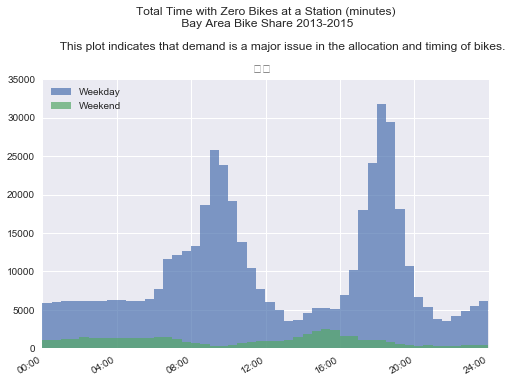

In [3]:
plt.show()

# Define functions for distance calculations

In [ ]:
# create a lat lon station vs station distance table. Station names in columns and indices. Use this as a lookup 
# table to determine stations within X miles

#define a function to compute lat-lon based distances in miles
def great_circle_distance(lat1,long1,lat2,long2):
    
    #great circle distance from 
    #haversine distance equation
    #http://www.movable-type.co.uk/scripts/latlong.html
    #calculate the lat long distances
    rVar = 6371e3;#  metres
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    delPhi = np.deg2rad(lat2-lat1)
    delLam = np.deg2rad(long2-long1)

    aVar = np.sin(delPhi/2) * np.sin(delPhi/2) +             np.cos(phi1) * np.cos(phi2) *             np.sin(delLam/2) * np.sin(delLam/2);
    cVar = 2 * np.arctan2(np.sqrt(aVar), np.sqrt(1-aVar));

    dVar = (rVar * cVar)*0.000621371;#conversion to miles
    
    return dVar


# define function to return the station ids within walking distance of a given station
def getStationsWithinWalking(SDM,stationID,walkingThreshold):
    
    stationArray=SDM[SDM[stationID]<=walkingThreshold][stationID]
    stationArray=stationArray[stationArray.index!=stationID].sort_values()
    
    stationFrame=pd.DataFrame(data=stationArray,index=stationArray.index)
    
    return stationFrame

# define the 
def getStation2StationDistance(SDM,stationIDStart,stationIDEnd):
    
    stationArray=SDM[stationIDStart]
    stationDistance=stationArray[stationArray.index==stationIDEnd]
    
    return stationDistance

# Analyze the station list

In [ ]:
# Query the station table
stationDF = pd.read_sql_query("SELECT * FROM station",con)

# compute the mile distance between each station, store in matrix form
stationDistanceMatrix=pd.DataFrame(index=stationDF['id'])

# this dataframe has station ID's for both the indices and column names
for indexCLL, rowCLL in stationDF.iterrows():
    stationDistanceMatrix[rowCLL['id']] = stationDF.set_index('id').apply(lambda row: great_circle_distance(row['lat'],row['long'],rowCLL['lat'],rowCLL['long']), axis=1)

# Analyze the weather data

In [ ]:
# read this table from its CSV format to retain the NaNs since there are many in this dataset and i want to use pandas filling on it
weatherDF=pd.read_csv('C:/Users/Thomas/Documents/IPython Notebooks/weather.csv')

# cleaning the data and there are instances of Rain and rain in the set, so making that just one
weatherDF['events'].replace('rain','Rain',inplace=True)

# transform the different weather events to a vectorized form for the regression model to utilize
vecEvents = DictVectorizer()

# make a subset dataframe of just the data we want to transform
loneEvents=pd.DataFrame(data=weatherDF['events'])

# convert the dataframe to a dictionary
trEvents=loneEvents.to_dict(orient="records")

# fit and transform the dictionary into the matrix of zeros and ones
vEvents=vecEvents.fit_transform(trEvents)

# convert the output to an array
outEvents=vEvents.toarray()

# get rid of the occurence of a non-event, this is taken care of as a feature by the absence of the other events
outEvents=outEvents[:,1:]

# merge this newly created feature set back into the original weather dataframe
weatherDF=pd.merge(weatherDF,pd.DataFrame(columns=vecEvents.get_feature_names()[1:],data=outEvents,index=weatherDF.index),how='left',left_index=True,right_index=True)

# rearrange the columns so x,y are left and right
newCols=np.append(weatherDF.columns.tolist()[:-5],np.append(weatherDF.columns.tolist()[-4:],weatherDF.columns.tolist()[-5:-4]))

# get rid of the old events column
mask = np.ones(len(newCols), dtype=bool)
mask[[newCols=='events']] = False
newCols=newCols[mask]
weatherDF=weatherDF[newCols]

#not sure what T stands for so its going to be zeroed out
weatherDF['precipitation_inches']=pd.to_numeric(weatherDF['precipitation_inches'],errors='coerce')


# separate the weather by zip code in order to interpolate the NaN values effectively
uniqueZips=weatherDF['zip_code'].unique()

# generate the separated dataframes
separatedZipCodeWeatherDFs=[pd.DataFrame(columns=weatherDF.columns[:-1],data=weatherDF[weatherDF['zip_code']==ii][weatherDF.columns[:-1]]) for ii in uniqueZips]

# create new columns on a per zip code basis so that they all line up with the same indexed time
for counter,sepDF in enumerate(separatedZipCodeWeatherDFs):

	# name the columns
    sepDF.columns=[x+'_'+str(uniqueZips[counter]) for x in sepDF.columns]
	
	# now interpolate the NaN values using only surrounding values from that zip code
    sepDF.interpolate(inplace=True)
    
    #set the common time index
    sepDF.set_index(sepDF.columns[0],inplace=True)


# merge all of the separated dataframes back together under the same time index
weatherFinal = separatedZipCodeWeatherDFs[0]
for sepDF in separatedZipCodeWeatherDFs[1:]:
    weatherFinal = weatherFinal.merge(sepDF,how='outer',left_index=True,right_index=True)

weatherFinal.head()

# change the format of the index to a days form for later
weatherFinal['dateIndex']=pd.DatetimeIndex(pd.to_datetime(weatherFinal.index, format='%m/%d/%Y')).date

weatherFinal.set_index('dateIndex',inplace=True)

# Analyze the bike station status data

In [ ]:
# Now go through the giant minute by minute account of bikes at each station. I am going to reduce down this dataset to the 
# values at the half past the hour mark to be used to represent the whole hour
EveryHourInStatusSpan= pd.read_sql_query("SELECT time,station_id,bikes_available FROM status WHERE time LIKE '%:30:%'",con)


# set up an initial inflow / outflow and status dataframe
FlowAndStatusDF=pd.DataFrame(index=pd.date_range('2013-8-29', periods=17592, freq='H'))

# make this a float so that it isnt seen as some kind of category.
# This is reasonably good indicator for the season of the year
FlowAndStatusDF['numberDayOfYear']=FlowAndStatusDF.index.dayofyear.astype('float64')

# make a day of the week to be used in the model
FlowAndStatusDF['dayOfWeek']=FlowAndStatusDF.index.dayofweek

#make this a float so that it isnt seen as some kind of category
FlowAndStatusDF['hour']=FlowAndStatusDF.index.hour.astype('float64')

# make the date in the compatible format
FlowAndStatusDF['date']=FlowAndStatusDF.index.date

# extract the index so it isnt lost
FlowAndStatusDF['dateIndex']=FlowAndStatusDF.index

# load in the US federal holiday list, make it a feature
# these lines courtesy of https://www.kaggle.com/currie32/a-model-to-predict-number-of-daily-trips
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=FlowAndStatusDF.index.date.min(), end=FlowAndStatusDF.index.date.max())
FlowAndStatusDF['isHoliday']=FlowAndStatusDF['date'].isin(holidays.date)

# change the date column to a DatetimeIndex type. This will allow for easier aligning of data
FlowAndStatusDF['date']=pd.DatetimeIndex(pd.to_datetime(FlowAndStatusDF['date'], format='%Y-%m-%d')).date

# set this column as the index
FlowAndStatusDF.set_index(['date'],inplace=True)

# now that this column is set (the dataframe is still not complete), merge it with the weather dataframe
weatherPlusFlowDF=pd.merge(FlowAndStatusDF,weatherFinal,left_index=True,right_index=True)

#then change the index back to hourly
weatherPlusFlowDF.set_index(['dateIndex'],inplace=True)

# now to run to giant compiler of information from the database for every half hour in the two year time data
for station_id in stationDF['id']:

    print('Working on station %d' % station_id)

	# query the time, station_id, and bikes available data columns for each 30 minute mark
    stationTable=pd.read_sql_query("SELECT time,station_id,bikes_available FROM status WHERE time LIKE '%%:30:%%' AND station_id=%s" % station_id,con)

	# Floor the hour since I want to align it with the other dataframes
    stationTable['date']=pd.DatetimeIndex(pd.to_datetime(stationTable['time'], format='%Y-%m-%d')).floor('H')

	#set this common date format as the index
    stationTable.set_index('date',inplace=True);

	#get rid of everything except the bikes available column
    stationTable=stationTable[['bikes_available']]
	
	#make a status column for this station
    stationTable.columns=[str(station_id)+'_STAT']

	# merge this little dataframe into the larger dataframe that has weather and other things
    weatherPlusFlowDF=pd.merge(weatherPlusFlowDF,stationTable,how='left',left_index=True,right_index=True)
	
	# now fill in any gaps that may have occured in the recording by interpolating between hours
    weatherPlusFlowDF[stationTable.columns[0]].interpolate(inplace=True)


## if this previous table had already been created, I reloaded it with pickling
# weatherPlusFlowDF.to_pickle('C:/Users/Thomas/Documents/IPython Notebooks/weatherPlusFlowDF.pickle')
# weatherPlusFlowDF=pd.read_pickle('C:/Users/Thomas/Documents/IPython Notebooks/weatherPlusFlowDF.pickle')

# Analyze the trip data

In [ ]:
#get the trip data to sum up per hour at each station
tripDF = pd.read_sql_query("SELECT * FROM trip",con)


# trip start time info
tripTimeStartIndex=pd.DatetimeIndex(pd.to_datetime(tripDF.start_date, format='%m/%d/%Y %H:%M'))
tripDF['hourDeparture']=tripTimeStartIndex.hour
tripDF['dateDeparture']=tripTimeStartIndex.date
# floor out any trips that leave within an hour to be binned in that hour
tripDF['timeDeparture']=tripTimeStartIndex.floor('H')

# trip end time info
tripTimeEndIndex=pd.DatetimeIndex(pd.to_datetime(tripDF.end_date, format='%m/%d/%Y %H:%M'))
tripDF['hourArrival']=tripTimeEndIndex.hour
tripDF['dateArrival']=tripTimeEndIndex.date
# floor out any trips that arrive within an hour to be binned in that hour
tripDF['timeArrival']=tripTimeEndIndex.floor('H')

# for doing some counting later. I could not figure out how to get around doing this, I know its not elegant
tripDF['counts']=(tripDF['start_station_id']/tripDF['start_station_id']).astype(int)  

# now count up the number of occurences of trips that happen within each hour's timespan at each station
for station_id in stationDF['id']:

	# sum the occurences going out
    colNameOUT='%d_OUT' % station_id    
    stationOUTDF=(tripDF[tripDF['start_station_id']==station_id].groupby('timeDeparture')['counts']
    .agg({colNameOUT: np.sum}))   
	
	# sum the occurences coming in
    colNameIN='%d_IN' % station_id    
    stationINDF=(tripDF[tripDF['end_station_id']==station_id].groupby('timeArrival')['counts']
    .agg({colNameIN: np.sum}))   
    
	# merge the little dataframes for INflow and OUTflow with the ever-growing one for the model fitting
    weatherPlusFlowDF=pd.merge(weatherPlusFlowDF,stationOUTDF,how='left',left_index=True,right_index=True)
    weatherPlusFlowDF=pd.merge(weatherPlusFlowDF,stationINDF,how='left',left_index=True,right_index=True)
	
	# make any NaNs filled with zeros for this data once merged in
    weatherPlusFlowDF[[colNameOUT]]=weatherPlusFlowDF[[colNameOUT]].fillna(0)
    weatherPlusFlowDF[[colNameIN]]=weatherPlusFlowDF[[colNameIN]].fillna(0)
    

	

# Grid Search cross validation for gradient boosting algorithm

In [ ]:
# # # #
# # # # This is the code to run the GridSearchCV on the highest traffic volume station to get parameters for the rest of regressors
# # # # I leave it commented out since it takes some time to run and is ony relevant in order to determine parameters for the rest of
# # # # the models. 
# # # #

# # # # The station that has the highest summed inflow OR outflow is used at the hyper-parameter tailoring subset
# # # stationCurrent=int(weatherPlusFlowDF[weatherPlusFlowDF.columns[200:]].sum().argmax()[:-3])

# # # # use the gradient boosting regressor for this problem, if given more time Id compare models together
# # # gradBoosterIN = GradientBoostingRegressor(random_state = 0)
# # # gradBoosterOUT = GradientBoostingRegressor(random_state = 0)
# # # gradBoosterSTAT = GradientBoostingRegressor(random_state = 0)

# # # # search for n_estimators and learning rate optimum values
# # # grid_values={'n_estimators':[100,150,200],'learning_rate':[0.1,0.2,0.3]}

# # # # run each one parallelized and make my computer hate me
# # # grid_gradBoostIN = GridSearchCV(gradBoosterIN, param_grid = grid_values,n_jobs=-1)
# # # grid_gradBoostOUT = GridSearchCV(gradBoosterOUT, param_grid = grid_values,n_jobs=-1)
# # # grid_gradBoostSTAT = GridSearchCV(gradBoosterSTAT, param_grid = grid_values,n_jobs=-1)



# # # grid_gradBoostIN.fit(byHour_X_train,byHour_y_train_IN)
# # # print('Completed IN')
# # # grid_gradBoostOUT.fit(byHour_X_train,byHour_y_train_OUT)
# # # print('Completed OUT')
# # # grid_gradBoostSTAT.fit(byHour_X_train,byHour_y_train_STAT)
# # # print('Completed STAT')


# # # # print out lots of stats about things. One thing I noticed was that the STAT models are far worse fitting than the IN and OUT
# # # # models seem to be. I suspect this might have to do with the fact that many bike sharing organizations already reallocate bikes
# # # # using trucks in the night. If given more time I would investigate to see if it could be proven just with the data given
# # # print('Best Parameter Grid Search Training Score IN: %0.4f' % grid_gradBoostIN.score(byHour_X_train,byHour_y_train_IN))
# # # print('Best Parameter Grid Search Training Score OUT: %0.4f' % grid_gradBoostOUT.score(byHour_X_train,byHour_y_train_OUT))
# # # print('Best Parameter Grid Search Training Score STAT: %0.4f' % grid_gradBoostSTAT.score(byHour_X_train,byHour_y_train_STAT))

# # # # test scores looked good for this station
# # # print('Best Parameter Grid Search Test Score IN: %0.4f' % grid_gradBoostIN.score(byHour_X_test,byHour_y_test_IN))
# # # print('Best Parameter Grid Search Test Score OUT: %0.4f' % grid_gradBoostOUT.score(byHour_X_test,byHour_y_test_OUT))
# # # print('Best Parameter Grid Search Test Score STAT: %0.4f' % grid_gradBoostSTAT.score(byHour_X_test,byHour_y_test_STAT))

# # # # find out the best parameters from the search
# # # print(grid_gradBoostIN.best_params_)
# # # print(grid_gradBoostOUT.best_params_)
# # # print(grid_gradBoostSTAT.best_params_)
# # # grid_gradBoostIN.cv_results_

# # # #run some predictions of results and plot them
# # # y_predict_trainIN=grid_gradBoostIN.predict(byHour_X_train)
# # # y_predict_testIN=grid_gradBoostIN.predict(byHour_X_test)

# # # y_predict_trainOUT=grid_gradBoostOUT.predict(byHour_X_train)
# # # y_predict_testOUT=grid_gradBoostOUT.predict(byHour_X_test)

# # # y_predict_trainSTAT=grid_gradBoostSTAT.predict(byHour_X_train)
# # # y_predict_testSTAT=grid_gradBoostSTAT.predict(byHour_X_test)

# # # trainFigIN=plt.figure()
# # # plt.plot(byHour_y_train_IN[700:800],label='Actual Training Results')
# # # plt.plot(y_predict_trainIN[700:800].round(),label='Predicted Training Results')
# # # plt.legend()
# # # plt.title('Training Data Subset Prediction vs Actual for Number of Arrivals to Station')

# # # testFigIN=plt.figure()
# # # plt.plot(byHour_y_test_IN[700:800],label='Actual Test Results')
# # # plt.plot(y_predict_testIN[700:800].round(),label='Predicted Test Results')
# # # plt.legend()
# # # plt.title('Test Data Subset Prediction vs Actual for Number of Arrivals to Station')

# # # trainFigOUT=plt.figure()
# # # plt.plot(byHour_y_train_OUT[700:800],label='Actual Training Results')
# # # plt.plot(y_predict_trainOUT[700:800].round(),label='Predicted Training Results')
# # # plt.legend()
# # # plt.title('Training Data Subset Prediction vs Actual for Number of Departures from Station')

# # # testFigOUT=plt.figure()
# # # plt.plot(byHour_y_test_OUT[700:800],label='Actual Test Results')
# # # plt.plot(y_predict_testOUT[700:800].round(),label='Predicted Test Results')
# # # plt.legend()
# # # plt.title('Test Data Subset Prediction vs Actual for Number of Departures from Station')

# # # trainFig=plt.figure()
# # # plt.plot(byHour_y_train_STAT[700:800],label='Actual Training Results')
# # # plt.plot(y_predict_trainSTAT[700:800].round(),label='Predicted Training Results')
# # # plt.legend()
# # # plt.title('Training Data Subset Prediction vs Actual for Number of Bikes at Station')

# # # testFig=plt.figure()
# # # plt.plot(byHour_y_test_STAT[700:800],label='Actual Test Results')
# # # plt.plot(y_predict_testSTAT[700:800].round(),label='Predicted Test Results')
# # # plt.legend()
# # # plt.title('Test Data Subset Prediction vs Actual for Number of Bikes at Station')






# If the models have already been run, I created pickles for a the whole set

# # If this has already been run dont run the model fitting again, just unpickle the resulting models
# fn='gradBoostersIN'
# # Dump the trained decision tree classifier with Pickle
# var_filename = 'C:/Users/Thomas/Documents/IPython Notebooks/%s.pkl' %fn
# # Open the file to save as pkl file
# var_pkl = open(var_filename, 'rb')
# gradBoostersIN=pickle.load(var_pkl)
# var_pkl.close()

# fn='gradBoostersOUT'
# # Dump the trained decision tree classifier with Pickle
# var_filename = 'C:/Users/Thomas/Documents/IPython Notebooks/%s.pkl' %fn
# # Open the file to save as pkl file
# var_pkl = open(var_filename, 'rb')
# gradBoostersOUT=pickle.load(var_pkl)
# var_pkl.close()

# fn='gradBoostersSTAT'
# # Dump the trained decision tree classifier with Pickle
# var_filename = 'C:/Users/Thomas/Documents/IPython Notebooks/%s.pkl' %fn
# # Open the file to save as pkl file
# var_pkl = open(var_filename, 'rb')
# gradBoostersSTAT=pickle.load(var_pkl)
# var_pkl.close()

# fn='predictTableTest'
# # Dump the trained decision tree classifier with Pickle
# var_filename = 'C:/Users/Thomas/Documents/IPython Notebooks/%s.pkl' %fn
# # Open the file to save as pkl file
# var_pkl = open(var_filename, 'rb')
# predictTableTest=pickle.load(var_pkl)
# var_pkl.close()

# fn='predictTableTrain'
# # Dump the trained decision tree classifier with Pickle
# var_filename = 'C:/Users/Thomas/Documents/IPython Notebooks/%s.pkl' %fn
# # Open the file to save as pkl file
# var_pkl = open(var_filename, 'rb')
# predictTableTrain=pickle.load(var_pkl)
# var_pkl.close()

## Create a gradient boosting model for each statistic (INflow, OUTflow, AND Bikes available(STAT)) at each station

##### I above did a very brief tuning / cross validation grid search on the highest "flow" station to arrive at the parameters of n_estimators= 100, learning_rate= 0.1 for the models. If I had more time, I would focus on exploring the design space of the algorithm for this problem. Even using every hour of data for two years does not result in a very robust dataset to fit these models with, and that is also something i would explore with more time.

In [ ]:
gradBoostersIN=[]
gradBoostersOUT=[]
gradBoostersSTAT=[]

# do the train / test split on just the full day. Then using this random split info, extract the entire day's worth of hour
# info and put it into the set that its day is separated to. The nan reduced sets are not used to determine the train/test split
# so that the same data can be used across all station predictors (subtracting out the nans of course)

dateList=np.unique(weatherPlusFlowDF.index.date)

splitDateList=pd.DataFrame(index=dateList,columns=['dummy'])

# split the days into training and test days
X_train, X_test, y_train, y_test = train_test_split(splitDateList.index, splitDateList['dummy'], random_state = 0)

# setup the prediction scoring tables
predictTableTrain=pd.DataFrame(index=weatherPlusFlowDF.index)
predictTableTest=pd.DataFrame(index=weatherPlusFlowDF.index)

scoresTrainIN=[]
scoresTrainOUT=[]
scoresTrainSTAT=[]

scoresTestIN=[]
scoresTestOUT=[]
scoresTestSTAT=[]


# loop over every station and build the model for each one!
for stationIndex,stationCurrent in enumerate(stationDF['id']):
    
    print('Working on station %d...' % stationCurrent)


    # each station has its own subset data containing only information from that station
    columnsForCurrentModel=np.append(weatherPlusFlowDF.columns.tolist()[:129],
                                     np.append('%d_IN' % stationCurrent,
                                               np.append('%d_OUT' % stationCurrent,
                                                         '%d_STAT' % stationCurrent)))


	# drop any dates that dont yet have data for that station, most likely
	# due to the fact that the station didnt yet exist at some points in time
    subsetDF=weatherPlusFlowDF[columnsForCurrentModel].dropna(how='any')

    # split off the outputs to predict for each of the three models
    y_Vals_IN=subsetDF[columnsForCurrentModel[-3]]
    y_Vals_OUT=subsetDF[columnsForCurrentModel[-2]]
    y_Vals_STAT=subsetDF[columnsForCurrentModel[-1]]


    # the inputs are the same across all three of these models
    x_Vals=subsetDF[subsetDF.columns[:-3]]

    # separate data for every hour of the training and test days respectively
    byHour_X_train=x_Vals[np.isin(x_Vals.index.date,X_train)]
    byHour_X_test=x_Vals[np.isin(x_Vals.index.date,X_test)]

    #sample y_train and y_test based on a single station predicting IN, OUT, and STAT parameters
    byHour_y_train_IN=y_Vals_IN[np.isin(y_Vals_IN.index.date,X_train)].ravel()
    byHour_y_test_IN=y_Vals_IN[np.isin(y_Vals_IN.index.date,X_test)].ravel()
    byHour_y_train_OUT=y_Vals_OUT[np.isin(y_Vals_OUT.index.date,X_train)].ravel()
    byHour_y_test_OUT=y_Vals_OUT[np.isin(y_Vals_OUT.index.date,X_test)].ravel()
    byHour_y_train_STAT=y_Vals_STAT[np.isin(y_Vals_STAT.index.date,X_train)].ravel()
    byHour_y_test_STAT=y_Vals_STAT[np.isin(y_Vals_STAT.index.date,X_test)].ravel()



#---------if not already fit, uncomment
    
    #the regressor is using the parameters optimum in the grid search
    gbIN = GradientBoostingRegressor(random_state = 0,n_estimators= 100, learning_rate= 0.1)   
    gbOUT = GradientBoostingRegressor(random_state = 0,n_estimators= 100, learning_rate= 0.1)    
    gbSTAT = GradientBoostingRegressor(random_state = 0,n_estimators= 100, learning_rate= 0.1)    
    
	# fit the regressors to the data
    gbIN.fit(byHour_X_train,byHour_y_train_IN)
    gbOUT.fit(byHour_X_train,byHour_y_train_OUT)
    gbSTAT.fit(byHour_X_train,byHour_y_train_STAT)
    
# #--------if already fit, just bring up the final model    
#     gbIN=gradBoostersIN[stationIndex]
#     gbOUT=gradBoostersOUT[stationIndex]
#     gbSTAT=gradBoostersSTAT[stationIndex]
    
	# score the training set on the models, save them off to data sets of scores for each station
    scoresTrainIN.append(gbIN.score(byHour_X_train,byHour_y_train_IN))
    scoresTrainOUT.append(gbOUT.score(byHour_X_train,byHour_y_train_OUT))
    scoresTrainSTAT.append(gbSTAT.score(byHour_X_train,byHour_y_train_STAT))
    
	# score the test set on the models, save them off to data sets of scores for each station
    scoresTestIN.append(gbIN.score(byHour_X_test,byHour_y_test_IN))
    scoresTestOUT.append(gbOUT.score(byHour_X_test,byHour_y_test_OUT))
    scoresTestSTAT.append(gbSTAT.score(byHour_X_test,byHour_y_test_STAT))
    
    
    # create the equivalent of the original dataframe containing actual inflow, outflow and bikes available, but just for predicted
	# data instead of actual data for the training set data
    tempAddTrainIN=pd.DataFrame(index=byHour_X_train.index,data=gbIN.predict(byHour_X_train),columns=['%d_IN' % stationCurrent])
    tempAddTrainOUT=pd.DataFrame(index=byHour_X_train.index,data=gbOUT.predict(byHour_X_train),columns=['%d_OUT' % stationCurrent])
    tempAddTrainSTAT=pd.DataFrame(index=byHour_X_train.index,data=gbSTAT.predict(byHour_X_train),columns=['%d_STAT' % stationCurrent])
	
    # create the equivalent of the original dataframe containing actual inflow, outflow and bikes available, but just for predicted
	# data instead of actual data for the test set data
    tempAddTestIN=pd.DataFrame(index=byHour_X_test.index,data=gbIN.predict(byHour_X_test),columns=['%d_IN' % stationCurrent])
    tempAddTestOUT=pd.DataFrame(index=byHour_X_test.index,data=gbOUT.predict(byHour_X_test),columns=['%d_OUT' % stationCurrent])
    tempAddTestSTAT=pd.DataFrame(index=byHour_X_test.index,data=gbSTAT.predict(byHour_X_test),columns=['%d_STAT' % stationCurrent])

    # merge to the large dataframe for the training portion
    predictTableTrain=pd.merge(predictTableTrain,tempAddTrainIN,how='left',left_index=True,right_index=True)
    predictTableTrain=pd.merge(predictTableTrain,tempAddTrainOUT,how='left',left_index=True,right_index=True)
    predictTableTrain=pd.merge(predictTableTrain,tempAddTrainSTAT,how='left',left_index=True,right_index=True)
    
    # merge to the large dataframe for the test portion
    predictTableTest=pd.merge(predictTableTest,tempAddTestIN,how='left',left_index=True,right_index=True)
    predictTableTest=pd.merge(predictTableTest,tempAddTestOUT,how='left',left_index=True,right_index=True)
    predictTableTest=pd.merge(predictTableTest,tempAddTestSTAT,how='left',left_index=True,right_index=True)

	# save off all of the models into arrays
    gradBoostersIN.append(gbIN)
    gradBoostersOUT.append(gbOUT)
    gradBoostersSTAT.append(gbSTAT)

# Run the reallocation strategy using the predictive models

In [ ]:
# actual data section

# gather all of the actual OUTflow and STAT data
columnsForFullActualStats=weatherPlusFlowDF.columns[129:]
fullActualStatsDF=weatherPlusFlowDF[columnsForFullActualStats].copy()

# split the actual data into training and test data
actualStatsTrain=fullActualStatsDF[np.isin(fullActualStatsDF.index.date,X_train)]
actualStatsTest=fullActualStatsDF[np.isin(fullActualStatsDF.index.date,X_test)]

# drop any data without all of the stations online
reducedActualTrain=actualStatsTrain.dropna(how='any').copy()
reducedActualTest=actualStatsTest.dropna(how='any').copy()


# build the actual training OUT and STAT data
reducedActualTrain['date']=reducedActualTrain.index.date
reducedActualTrain['hour']=reducedActualTrain.index.hour

actualBikesScoresSTAT_train=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))
actualBikesScoresOUT_train=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))


# build the actual test OUT and STAT data
reducedActualTest['date']=reducedActualTest.index.date
reducedActualTest['hour']=reducedActualTest.index.hour

actualBikesScoresSTAT_test=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))
actualBikesScoresOUT_test=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))


# predicted data section 

# drop any data without all of the stations online
reducedPredictionTrain=predictTableTrain.dropna(how='any').copy()
reducedPredictionTest=predictTableTest.dropna(how='any').copy()


# build the predicted training OUT and STAT data
reducedPredictionTrain['date']=reducedPredictionTrain.index.date
reducedPredictionTrain['hour']=reducedPredictionTrain.index.hour

predictedBikesScoresSTAT_train=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))
predictedBikesScoresOUT_train=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))


# build the predicted test OUT and STAT data
reducedPredictionTest['date']=reducedPredictionTest.index.date
reducedPredictionTest['hour']=reducedPredictionTest.index.hour

predictedBikesScoresSTAT_test=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))
predictedBikesScoresOUT_test=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date))


# for each day, determine the sum total at each station of the hourly OUTflow and STAT bike totals for the predicted training data 
predictedBikesScoresSTAT_train=reducedPredictionTrain.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_STAT')]].sum()))
predictedBikesScoresSTAT_train.columns=[stationDF['id']]
predictedBikesScoresOUT_train=reducedPredictionTrain.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_OUT')]].sum()))
predictedBikesScoresOUT_train.columns=[stationDF['id']]

# create two scoring methodologies, decided to use the allocationScores one for evaluation 
inNeedOfBikesScores_train=predictedBikesScoresSTAT_train.divide(predictedBikesScoresOUT_train)
allocationScores_train=predictedBikesScoresSTAT_train.multiply(predictedBikesScoresOUT_train)
#inNeedOfBikesScores_train
#allocationScores_train

# for each day, determine the sum total at each station of the hourly OUTflow and STAT bike totals for the predicted test data 
predictedBikesScoresSTAT_test=reducedPredictionTest.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_STAT')]].sum()))
predictedBikesScoresSTAT_test.columns=[stationDF['id']]
predictedBikesScoresOUT_test=reducedPredictionTest.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_OUT')]].sum()))
predictedBikesScoresOUT_test.columns=[stationDF['id']]

# create two scoring methodologies, decided to use the allocationScores one for evaluation 
inNeedOfBikesScores_test=predictedBikesScoresSTAT_test.divide(predictedBikesScoresOUT_test)
allocationScores_test=predictedBikesScoresSTAT_test.multiply(predictedBikesScoresOUT_test)
#inNeedOfBikesScores_test
#allocationScores_test

# for each day, determine the sum total at each station of the hourly OUTflow and STAT bike totals for the actual training data
actualBikesScoresSTAT_train=reducedActualTrain.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_STAT')]].sum()))
actualBikesScoresSTAT_train.columns=[stationDF['id']]
actualBikesScoresOUT_train=reducedActualTrain.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_OUT')]].sum()))
actualBikesScoresOUT_train.columns=[stationDF['id']]

# create two scoring methodologies, decided to use the allocationScores one for evaluation 
inNeedOfActualBikesScores_train=actualBikesScoresSTAT_train.divide(actualBikesScoresOUT_train)
allocationActualScores_train=actualBikesScoresSTAT_train.multiply(actualBikesScoresOUT_train)
#inNeedOfActualBikesScores_train
#allocationActualScores_train


# for each day, determine the sum total at each station of the hourly OUTflow and STAT bike totals for the actual test data 
actualBikesScoresSTAT_test=reducedActualTest.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_STAT')]].sum()))
actualBikesScoresSTAT_test.columns=[stationDF['id']]
actualBikesScoresOUT_test=reducedActualTest.groupby('date').apply(lambda x: (x[x.columns[x.columns.str.contains('_OUT')]].sum()))
actualBikesScoresOUT_test.columns=[stationDF['id']]

# create two scoring methodologies, decided to use the allocationScores one for evaluation 
inNeedOfActualBikesScores_test=actualBikesScoresSTAT_test.divide(actualBikesScoresOUT_test)
allocationActualScores_test=actualBikesScoresSTAT_test.multiply(actualBikesScoresOUT_test)
#inNeedOfActualBikesScores_test
#allocationActualScores_test


# create a blank dataframe to record the reallocation statistics
reallocationMatrixTraining=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date),columns=[stationDF['id']]).fillna(0)
reallocationMatrixTest=pd.DataFrame(index=np.unique(weatherPlusFlowDF.index.date),columns=[stationDF['id']]).fillna(0)


# set a maximum to steal from one station in one day
maxBikesRemoved=-96 #which is equal to 4 bikes for 24 hours
tripReallocList=[]


# Now run the simulation routine
# for each day in the test data set
for dayUsed in np.arange(len(allocationActualScores_test.index)):

	# for each trip taken in the latest 12 hours of the day prior to the test data day in question
	for index,row in tripDF[(tripDF['dateDeparture']==allocationActualScores_test.index[dayUsed]+datetime.timedelta(days=-1)) & (tripDF['hourDeparture']>=12)].iterrows():

		# check to see ifthe maximum threshold for bikes taken away from their desired station has been reached 
		if reallocationMatrixTest.loc[allocationScores_test.index[dayUsed]][row['end_station_id']]>maxBikesRemoved:


			# determine the alternative nearby end point stations to the current trip within a 4/10 mile tolerance
			nearbyStations=getStationsWithinWalking(stationDistanceMatrix,row['end_station_id'],0.4);

			if nearbyStations.size!=0:

				nearbyStations['idCol']=nearbyStations.index

				# RULE OUT nearby stations that are going to be inconvenient for the specific journey between start and end point for either of
				# two reasons: 
				# 1) the distance from the alternative destination to the desired destination is greater than the distance from the current 
				#    departure location to the desired destination, because then they might as well walk
				alt2desired=nearbyStations['idCol'].apply(lambda x: getStation2StationDistance(stationDistanceMatrix,x,row['end_station_id']))
				start2desired=getStation2StationDistance(stationDistanceMatrix,row['start_station_id'],row['end_station_id'])

				# alt2desired<start2desired
				rule1=start2desired-alt2desired

				# 2) the distance from the current departure location to the alternative destination is less than the distance between the 
				#    alternative destination and the desired destination because then its not encompassing the majority of the journey
				start2alt=nearbyStations['idCol'].apply(lambda x: getStation2StationDistance(stationDistanceMatrix,x,row['start_station_id']))
				start2alt.columns=[row['end_station_id']]

				# start2alt>alt2desired
				rule2=start2alt-alt2desired

				rulesMerged=pd.merge(rule1,rule2,how='inner',left_index=True,right_index=True)

				validStationsDistance=np.array(rulesMerged.where(rulesMerged>0).dropna(how='any').index.tolist())

				# if there are still valid stations after the reduction, run the computation on which ones would prove beneficial from a
				# metrics standpoint. 
				if validStationsDistance.size!=0:
				
					# go through each station and determine whether there is a predicted benefit from moving the trip to the new destination
					deltaAllocationScore=pd.Series(index=validStationsDistance)

					for x in validStationsDistance:

						# this allocation score uses a relaxation factor that starts reducing the benefit of sending bikes to the same alternate
						# location after the first instance that day. This way one station which statistically is supposed to be better that day
						# doesnt just get everything
						deltaAllocationScore.loc[x]=(predictedBikesScoresOUT_test[predictedBikesScoresOUT_test.index==allocationScores_test.index[dayUsed]][x]*(24/
													 (1+np.abs((reallocationMatrixTest.loc[allocationScores_test.index[dayUsed]][x])/48))))[0]

					# this score calculates the negative effect of the bike not going to the desired destination 
					negativeEffectScore=(predictedBikesScoresOUT_test[predictedBikesScoresOUT_test.index==allocationScores_test.index[dayUsed]][row['end_station_id']]*24)[0]

					# if there is a benefit to reallocating (1.3x greater than the loss for conservativeness)
					if (deltaAllocationScore-negativeEffectScore).max()>negativeEffectScore*1.3:
		                # print('changing route for trip %d to arrive at station %d instead of %d' % (index,(deltaAllocationScore-negativeEffectScore).argmax(),row['end_station_id']))
						tripReallocList.append([index,(deltaAllocationScore-negativeEffectScore).argmax(),row['end_station_id']])
						reallocationMatrixTest.loc[allocationScores_test.index[dayUsed]][(deltaAllocationScore-negativeEffectScore).argmax()]+=24
						reallocationMatrixTest.loc[allocationScores_test.index[dayUsed]][row['end_station_id']]-=24

# Plot the performance results of the reallocation

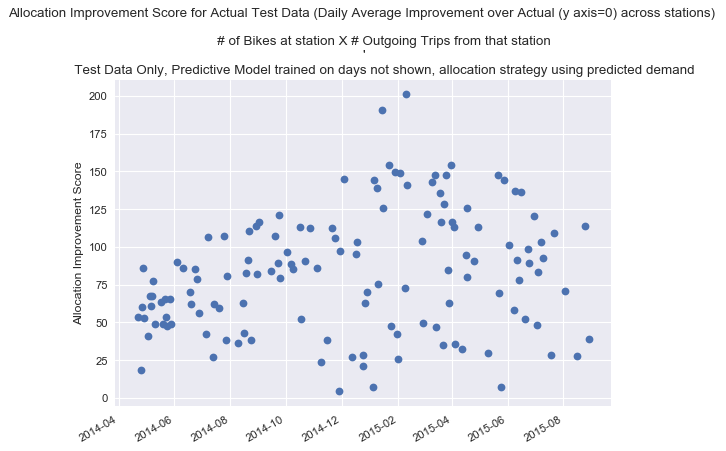

In [6]:
# Add the prediction-based reallocated bikes to the actual bike at station data, and then multiply by the actual OUTflow data
allocationPredictedTestOnActual=(reallocationMatrixTest.loc[actualBikesScoresOUT_test.index]+actualBikesScoresSTAT_test).multiply(actualBikesScoresOUT_test)

# compare this result with the baseline case of actual test data
figAlloc=plt.figure(figsize=(8, 6), dpi=80)
plt.plot(allocationPredictedTestOnActual.mean(axis=1)-allocationActualScores_test.mean(axis=1),'o')
plt.title(("""Allocation Improvement Score for Actual Test Data (Daily Average Improvement over Actual (y axis=0) across stations) \n
           # of Bikes at station X # Outgoing Trips from that station\n'
           Test Data Only, Predictive Model trained on days not shown, allocation strategy using predicted demand"""))
plt.ylabel('Allocation Improvement Score')
figAlloc.autofmt_xdate()
plt.show()

# Being above the zero point is an indication that the allocation had a net positive effect on the system!